In [16]:
import math
import numpy
import csv
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

Let us visualize the data. The data is simulated based on the parameters. With large enough sample size the histogram faithfully reflect the underlying distribution. 

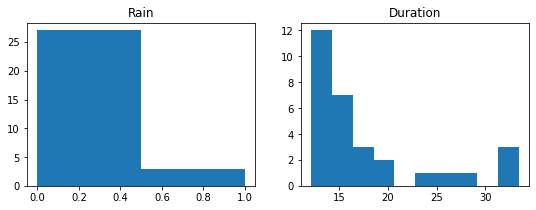

In [17]:
NOBS=30
with open(f"data-{NOBS}.csv") as f:
    rdr = csv.reader(f)
    next(rdr)
    rain = []
    duration = []
    for rec in rdr:
        rain.append(1 if rec[0] == "true" else 0)
        duration.append(float(rec[1]))

with PdfPages('data.pdf') as pdf:
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    ax[0].set_title('Rain')
    _ = ax[0].hist(rain, bins=2)
    ax[1].set_title('Duration')
    _ = ax[1].hist(duration)
    pdf.savefig()

Then, let us compare inference using the joint distribution of rain and duration (left) and marginal distributions of rain and duration (right), the latter using stochastic conditioning.

In [18]:
# We want to keep notebooks self-contained, so just put the ess estimator inline.
import scipy.fft

def ess(samples):
    """effective sample size"""    
    coeff = scipy.fft.fft(samples-samples.mean(), 2**int(numpy.floor(numpy.log2(len(samples)))))
    rhos = scipy.fft.ifft(coeff*numpy.conj(coeff))
    
    # compute effective sample size, stop when
    # the sum of two consecutive cross-correlations
    # becomes negative
    sum = 0.
    for i in range(1, len(samples)-1, 2):
        p = rhos[i] + rhos[i+1]
        if p < 0:
            break
        sum += p
    # cross-corellations are not normalized
    # and must be divided by cross-corellation at 0
    sum = numpy.real(sum/rhos[0])

    return len(samples) / (1. + sum)

deterministic, ess=8612


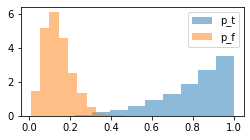

averaged, ess=5423


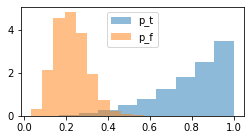

stochastic, ess=6444


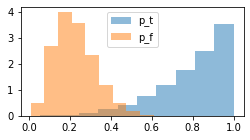

intensity, ess=7017


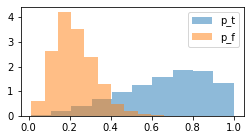

In [20]:
for setting in ["deterministic", "averaged", "stochastic", "intensity"]:
    post = numpy.genfromtxt(f"posterior-{NOBS}-{setting[0]}.csv", delimiter=",", skip_header=True)

    print(f"{setting}, ess={min(ess(post[:, 0]), ess(post[:, 1])):.0f}")
    plt.figure(figsize=(4, 2))
    plt.hist(post[:, 0], alpha=0.5, label="p_t", density=True)
    plt.hist(post[:, 1], alpha=0.5, label="p_f", density=True)
    plt.legend()
    plt.savefig(f"commute-posteriors-{setting}.pdf")
    plt.show()